In [15]:
import numpy as np
import cv2

In [16]:


def compute_mean_and_cov(image):
    """Compute mean and covariance of the color distribution."""
    reshaped = image.reshape(-1, 3).astype(np.float32)
    mean = np.mean(reshaped, axis=0)
    cov = np.cov(reshaped, rowvar=False)
    return mean, cov

def sqrtm(matrix, method="svd"):
    """Compute the square root of a positive semi-definite matrix."""
    if method == "svd":
        U, S, Vt = np.linalg.svd(matrix)
        return np.dot(U, np.dot(np.diag(np.sqrt(S)), Vt))
    elif method == "eigen":
        eigvals, eigvecs = np.linalg.eigh(matrix)
        sqrt_diag = np.diag(np.sqrt(eigvals))
        return eigvecs @ sqrt_diag @ eigvecs.T
    elif method == "cholesky":
        L = np.linalg.cholesky(matrix)
        return L
    else:
        raise ValueError("Invalid method for matrix square root")

def separable_transfer(target, reference):
    """Separable linear transfer (Reinhard et al.) - Matches means and variances independently."""
    target = target.astype(np.float32) / 255.0
    reference = reference.astype(np.float32) / 255.0

    mu_t, cov_t = compute_mean_and_cov(target)
    mu_r, cov_r = compute_mean_and_cov(reference)

    scale = np.sqrt(np.diag(cov_r)) / np.sqrt(np.diag(cov_t))
    transform = np.diag(scale)

    transformed = np.dot((target.reshape(-1, 3) - mu_t), transform.T) + mu_r
    transformed = np.clip(transformed, 0, 1)
    
    return (transformed.reshape(target.shape) * 255).astype(np.uint8)

def cholesky_transfer(target, reference):
    """Cholesky-based transfer."""
    target = target.astype(np.float32) / 255.0
    reference = reference.astype(np.float32) / 255.0

    mu_t, cov_t = compute_mean_and_cov(target)
    mu_r, cov_r = compute_mean_and_cov(reference)

    L_t = np.linalg.cholesky(cov_t)
    L_r = np.linalg.cholesky(cov_r)

    transform = L_r @ np.linalg.inv(L_t)
    
    transformed = np.dot((target.reshape(-1, 3) - mu_t), transform.T) + mu_r
    transformed = np.clip(transformed, 0, 1)

    return (transformed.reshape(target.shape) * 255).astype(np.uint8)

def pca_transfer(target, reference):
    """Principal Component Analysis (PCA)-based transfer."""
    target = target.astype(np.float32) / 255.0
    reference = reference.astype(np.float32) / 255.0

    mu_t, cov_t = compute_mean_and_cov(target)
    mu_r, cov_r = compute_mean_and_cov(reference)

    sqrt_cov_t = sqrtm(cov_t, method="eigen")
    sqrt_cov_r = sqrtm(cov_r, method="eigen")

    transform = sqrt_cov_r @ np.linalg.inv(sqrt_cov_t)

    transformed = np.dot((target.reshape(-1, 3) - mu_t), transform.T) + mu_r
    transformed = np.clip(transformed, 0, 1)

    return (transformed.reshape(target.shape) * 255).astype(np.uint8)

def monge_kantorovitch_transfer(target, reference):
    """Monge-Kantorovitch Optimal Transport-based transfer."""
    target = target.astype(np.float32) / 255.0
    reference = reference.astype(np.float32) / 255.0

    mu_t, cov_t = compute_mean_and_cov(target)
    mu_r, cov_r = compute_mean_and_cov(reference)

    sqrt_cov_t = sqrtm(cov_t, method="svd")
    inv_sqrt_cov_t = np.linalg.inv(sqrt_cov_t)
    mk_transform = inv_sqrt_cov_t @ sqrtm(sqrt_cov_t @ cov_r @ sqrt_cov_t, method="svd") @ inv_sqrt_cov_t

    transformed = np.dot((target.reshape(-1, 3) - mu_t), mk_transform.T) + mu_r
    transformed = np.clip(transformed, 0, 1)

    return (transformed.reshape(target.shape) * 255).astype(np.uint8)

def convert_color_space(image, from_space, to_space):
    """Convert image between different color spaces."""
    conversion_code = {
        ("RGB", "YUV"): cv2.COLOR_RGB2YUV,
        ("YUV", "RGB"): cv2.COLOR_YUV2RGB,
        ("RGB", "LAB"): cv2.COLOR_RGB2LAB,
        ("LAB", "RGB"): cv2.COLOR_LAB2RGB,
        ("RGB", "XYZ"): cv2.COLOR_RGB2XYZ,
        ("XYZ", "RGB"): cv2.COLOR_XYZ2RGB,
        ("RGB", "LUV"): cv2.COLOR_RGB2LUV,
        ("LUV", "RGB"): cv2.COLOR_LUV2RGB
    }
    return cv2.cvtColor(image, conversion_code[(from_space, to_space)])

import matplotlib.pyplot as plt

def run_all_transfers(target_path, reference_path, color_space="RGB"):
    """Run all color transfer methods and display results using Matplotlib."""
    target = cv2.imread(target_path)
    reference = cv2.imread(reference_path)

    if color_space != "RGB":
        target = convert_color_space(target, "RGB", color_space)
        reference = convert_color_space(reference, "RGB", color_space)

    results = {
        "Target": target,
        "Reference": reference,
        "Separable": separable_transfer(target, reference),
        "Cholesky": cholesky_transfer(target, reference),
        "PCA": pca_transfer(target, reference),
        "Monge-Kantorovitch": monge_kantorovitch_transfer(target, reference)
    }

    if color_space != "RGB":
        for key in results:
            results[key] = convert_color_space(results[key], color_space, "RGB")

    # Convert images from BGR (OpenCV default) to RGB for matplotlib
    for key in results:
        results[key] = cv2.cvtColor(results[key], cv2.COLOR_BGR2RGB)

    # Plot results
    plt.figure(figsize=(12, 8))
    for i, (name, img) in enumerate(results.items(), 1):
        plt.subplot(2, 3, i)
        plt.imshow(img)
        plt.title(name)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()




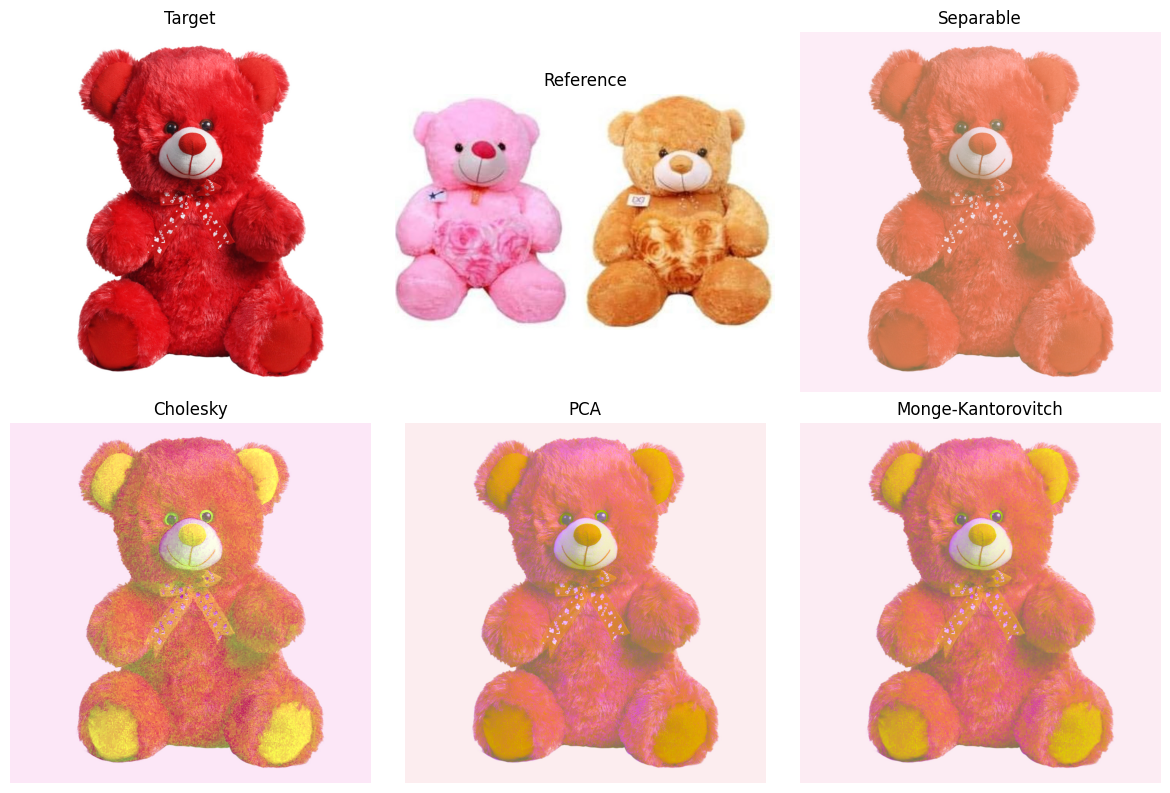

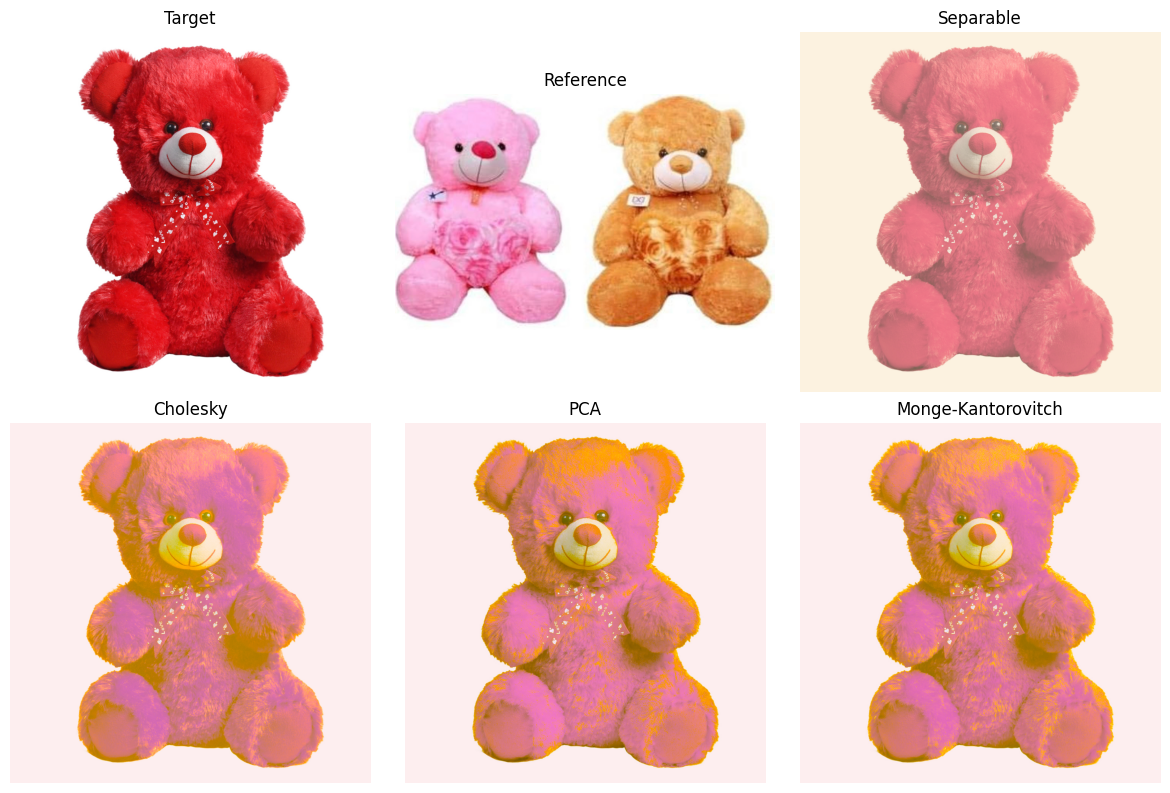

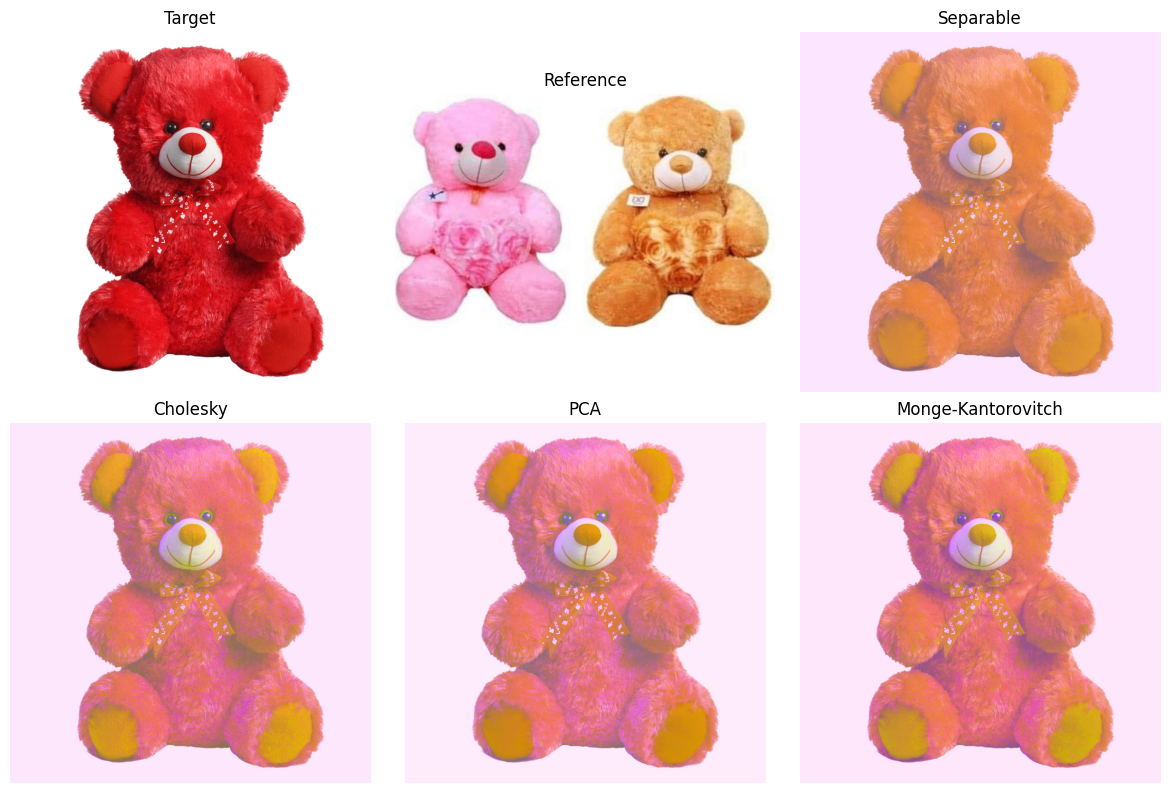

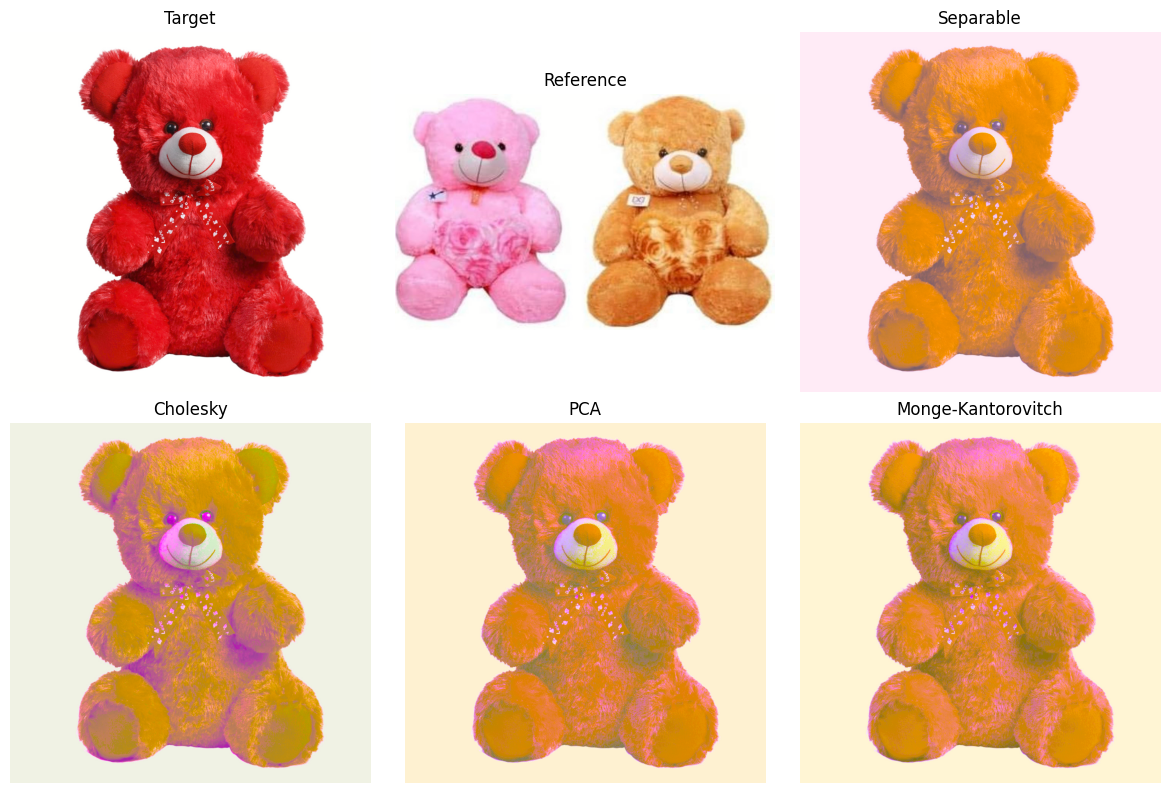

In [17]:
# Example Usage
if __name__ == "__main__":
    target_img_path = "/home/neelraj-reddy/college/6th_sem/computer vision/project/A little survey on previous works/images/reference.jpeg"
    reference_img_path = "/home/neelraj-reddy/college/6th_sem/computer vision/project/A little survey on previous works/images/input1.jpg"

    # Run all transfers in RGB
    run_all_transfers(target_img_path, reference_img_path, "RGB")

    # Run all transfers in LAB
    run_all_transfers(target_img_path, reference_img_path, "LAB")

    # Run all transfers in YUV
    run_all_transfers(target_img_path, reference_img_path, "YUV")

    # Run all transfers in CIELUV
    run_all_transfers(target_img_path, reference_img_path, "LUV")


In [21]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# ---------------------- 1. Matrix Transformations ----------------------

def rgb_to_xyz(rgb):
    """Convert RGB to XYZ color space."""
    M = np.array([[0.4124564, 0.3575761, 0.1804375],
                  [0.2126729, 0.7151522, 0.0721750],
                  [0.0193339, 0.1191920, 0.9503041]])
    return np.dot(rgb, M.T)

def xyz_to_lms(xyz):
    """Convert XYZ to LMS color space."""
    M = np.array([[0.4002, 0.7075, -0.0808],
                  [-0.2263, 1.1653, 0.0457],
                  [0.0000, 0.0000, 0.9182]])
    return np.dot(xyz, M.T)

def lms_to_lab(lms):
    """Convert LMS to lαβ color space."""
    lms = np.where(lms > 0, np.log(lms), 0)  # Apply log transformation
    M = np.array([[1/np.sqrt(3), 1/np.sqrt(3), 1/np.sqrt(3)],
                  [1/np.sqrt(6), 1/np.sqrt(6), -2/np.sqrt(6)],
                  [1/np.sqrt(2), -1/np.sqrt(2), 0]])
    return np.dot(lms, M.T)

def lab_to_lms(lab):
    """Convert lαβ to LMS color space."""
    M_inv = np.array([[1/np.sqrt(3), 1/np.sqrt(6), 1/np.sqrt(2)],
                      [1/np.sqrt(3), 1/np.sqrt(6), -1/np.sqrt(2)],
                      [1/np.sqrt(3), -2/np.sqrt(6), 0]])
    lms = np.dot(lab, M_inv.T)
    return np.exp(lms)  # Inverse log

def lms_to_xyz(lms):
    """Convert LMS to XYZ color space."""
    M_inv = np.array([[1.8601, -1.1295, 0.2199],
                      [0.3612, 0.6388, -0.0000],
                      [0.0000, 0.0000, 1.0891]])
    return np.dot(lms, M_inv.T)

def xyz_to_rgb(xyz):
    """Convert XYZ to RGB color space."""
    M_inv = np.array([[3.2404542, -1.5371385, -0.4985314],
                      [-0.9692660, 1.8760108, 0.0415560],
                      [0.0556434, -0.2040259, 1.0572252]])
    rgb = np.dot(xyz, M_inv.T)
    return np.clip(rgb, 0, 1)  # Clip values to ensure valid range

# ---------------------- 2. Compute Mean and Covariance ----------------------

def compute_mean_and_cov(image):
    """Compute mean and covariance of the color distribution."""
    reshaped = image.reshape(-1, 3).astype(np.float32)
    mean = np.mean(reshaped, axis=0)
    cov = np.cov(reshaped, rowvar=False)
    return mean, cov

# ---------------------- 3. Matrix Square Root ----------------------

def sqrtm(matrix, method="svd"):
    """Compute the square root of a positive semi-definite matrix."""
    if method == "svd":
        U, S, Vt = np.linalg.svd(matrix)
        return np.dot(U, np.dot(np.diag(np.sqrt(S)), Vt))
    elif method == "eigen":
        eigvals, eigvecs = np.linalg.eigh(matrix)
        sqrt_diag = np.diag(np.sqrt(eigvals))
        return eigvecs @ sqrt_diag @ eigvecs.T
    else:
        raise ValueError("Invalid method for matrix square root")

# ---------------------- 4. Color Transfer Methods ----------------------

def pca_transfer(target, reference):
    """PCA-based color transfer in lαβ space."""
    target = target.astype(np.float32) / 255.0
    reference = reference.astype(np.float32) / 255.0

    # RGB to XYZ to LMS to lαβ
    target_lab = lms_to_lab(xyz_to_lms(rgb_to_xyz(target)))
    reference_lab = lms_to_lab(xyz_to_lms(rgb_to_xyz(reference)))

    # Compute mean and covariance
    mu_t, cov_t = compute_mean_and_cov(target_lab)
    mu_r, cov_r = compute_mean_and_cov(reference_lab)

    # Apply PCA-based transformation
    sqrt_cov_t = sqrtm(cov_t, method="eigen")
    sqrt_cov_r = sqrtm(cov_r, method="eigen")

    transform = sqrt_cov_r @ np.linalg.inv(sqrt_cov_t)
    transformed_lab = np.dot((target_lab.reshape(-1, 3) - mu_t), transform.T) + mu_r
    transformed_lab = transformed_lab.reshape(target.shape)

    # lαβ to LMS to XYZ to RGB
    result_lms = lab_to_lms(transformed_lab)
    result_xyz = lms_to_xyz(result_lms)
    result_rgb = xyz_to_rgb(result_xyz)

    return (result_rgb * 255).astype(np.uint8)

def monge_kantorovitch_transfer(target, reference):
    """Monge-Kantorovitch Optimal Transport-based transfer in lαβ space."""
    target = target.astype(np.float32) / 255.0
    reference = reference.astype(np.float32) / 255.0

    # RGB to XYZ to LMS to lαβ
    target_lab = lms_to_lab(xyz_to_lms(rgb_to_xyz(target)))
    reference_lab = lms_to_lab(xyz_to_lms(rgb_to_xyz(reference)))

    # Compute mean and covariance
    mu_t, cov_t = compute_mean_and_cov(target_lab)
    mu_r, cov_r = compute_mean_and_cov(reference_lab)

    # Monge-Kantorovitch Optimal Transport
    sqrt_cov_t = sqrtm(cov_t, method="svd")
    inv_sqrt_cov_t = np.linalg.inv(sqrt_cov_t)
    mk_transform = inv_sqrt_cov_t @ sqrtm(sqrt_cov_t @ cov_r @ sqrt_cov_t, method="svd") @ inv_sqrt_cov_t

    transformed_lab = np.dot((target_lab.reshape(-1, 3) - mu_t), mk_transform.T) + mu_r
    transformed_lab = transformed_lab.reshape(target.shape)

    # lαβ to LMS to XYZ to RGB
    result_lms = lab_to_lms(transformed_lab)
    result_xyz = lms_to_xyz(result_lms)
    result_rgb = xyz_to_rgb(result_xyz)

    return (result_rgb * 255).astype(np.uint8)

# ---------------------- 5. Run All Transfers ----------------------

def run_all_transfers(target_path, reference_path):
    """Run all color transfer methods and display results."""
    target = cv2.imread(target_path)
    reference = cv2.imread(reference_path)

    # Convert BGR to RGB for processing
    target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)
    reference = cv2.cvtColor(reference, cv2.COLOR_BGR2RGB)

    results = {
        "Target": target,
        "Reference": reference,
        "PCA": pca_transfer(target, reference),
        "Monge-Kantorovitch": monge_kantorovitch_transfer(target, reference)
    }

    # Plot results
    plt.figure(figsize=(12, 8))
    for i, (name, img) in enumerate(results.items(), 1):
        plt.subplot(2, 2, i)
        plt.imshow(img)
        plt.title(name)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_23770/4267922603.py:23: RuntimeWarning: divide by zero encountered in log
  lms = np.where(lms > 0, np.log(lms), 0)  # Apply log transformation


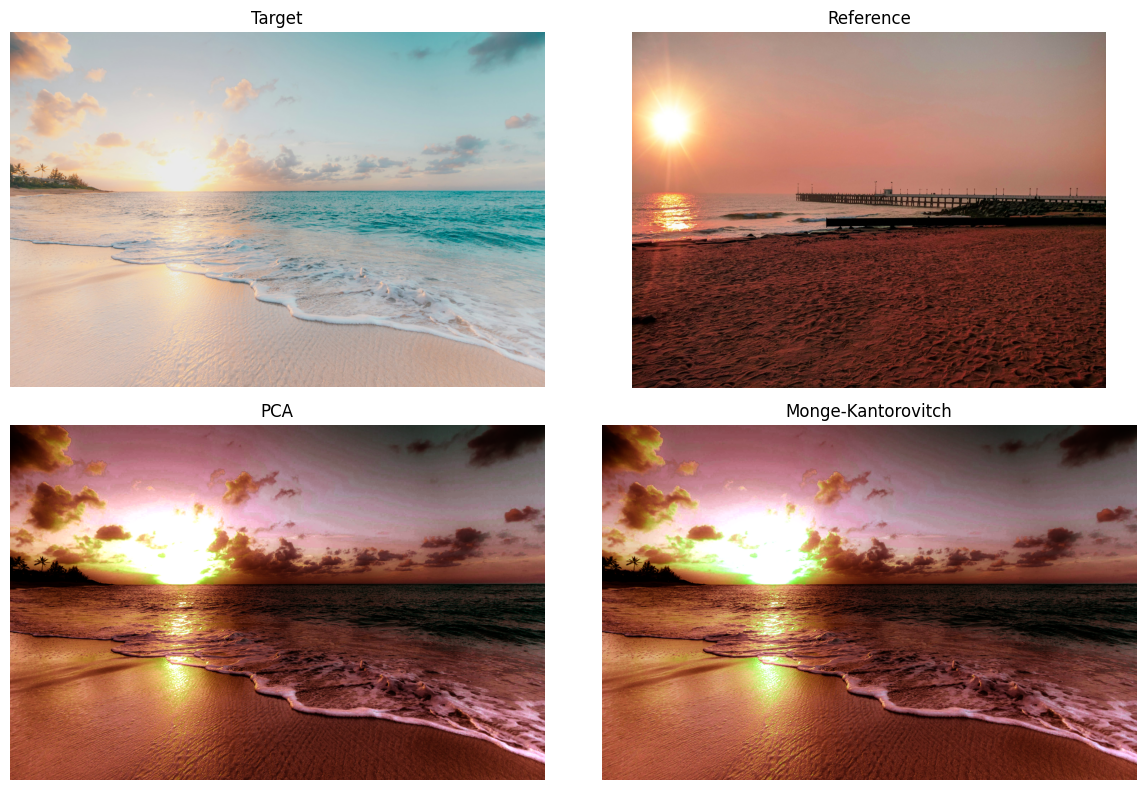

In [23]:
# ---------------------- 6. Example Usage ----------------------

if __name__ == "__main__":
    # Define paths for target and reference images
    target_img_path = "/home/neelraj-reddy/college/6th_sem/computer vision/project/A little survey on previous works/images/beach_ref.jpeg"
    reference_img_path = "/home/neelraj-reddy/college/6th_sem/computer vision/project/A little survey on previous works/images/beach_target.jpeg"

    # Run all transfers in lαβ space
    run_all_transfers(target_img_path, reference_img_path)
